INFO | Saved plot: ./plots\summary_grid.png
INFO | Saved plot: ./plots\test_reward_over_time__mean_.png


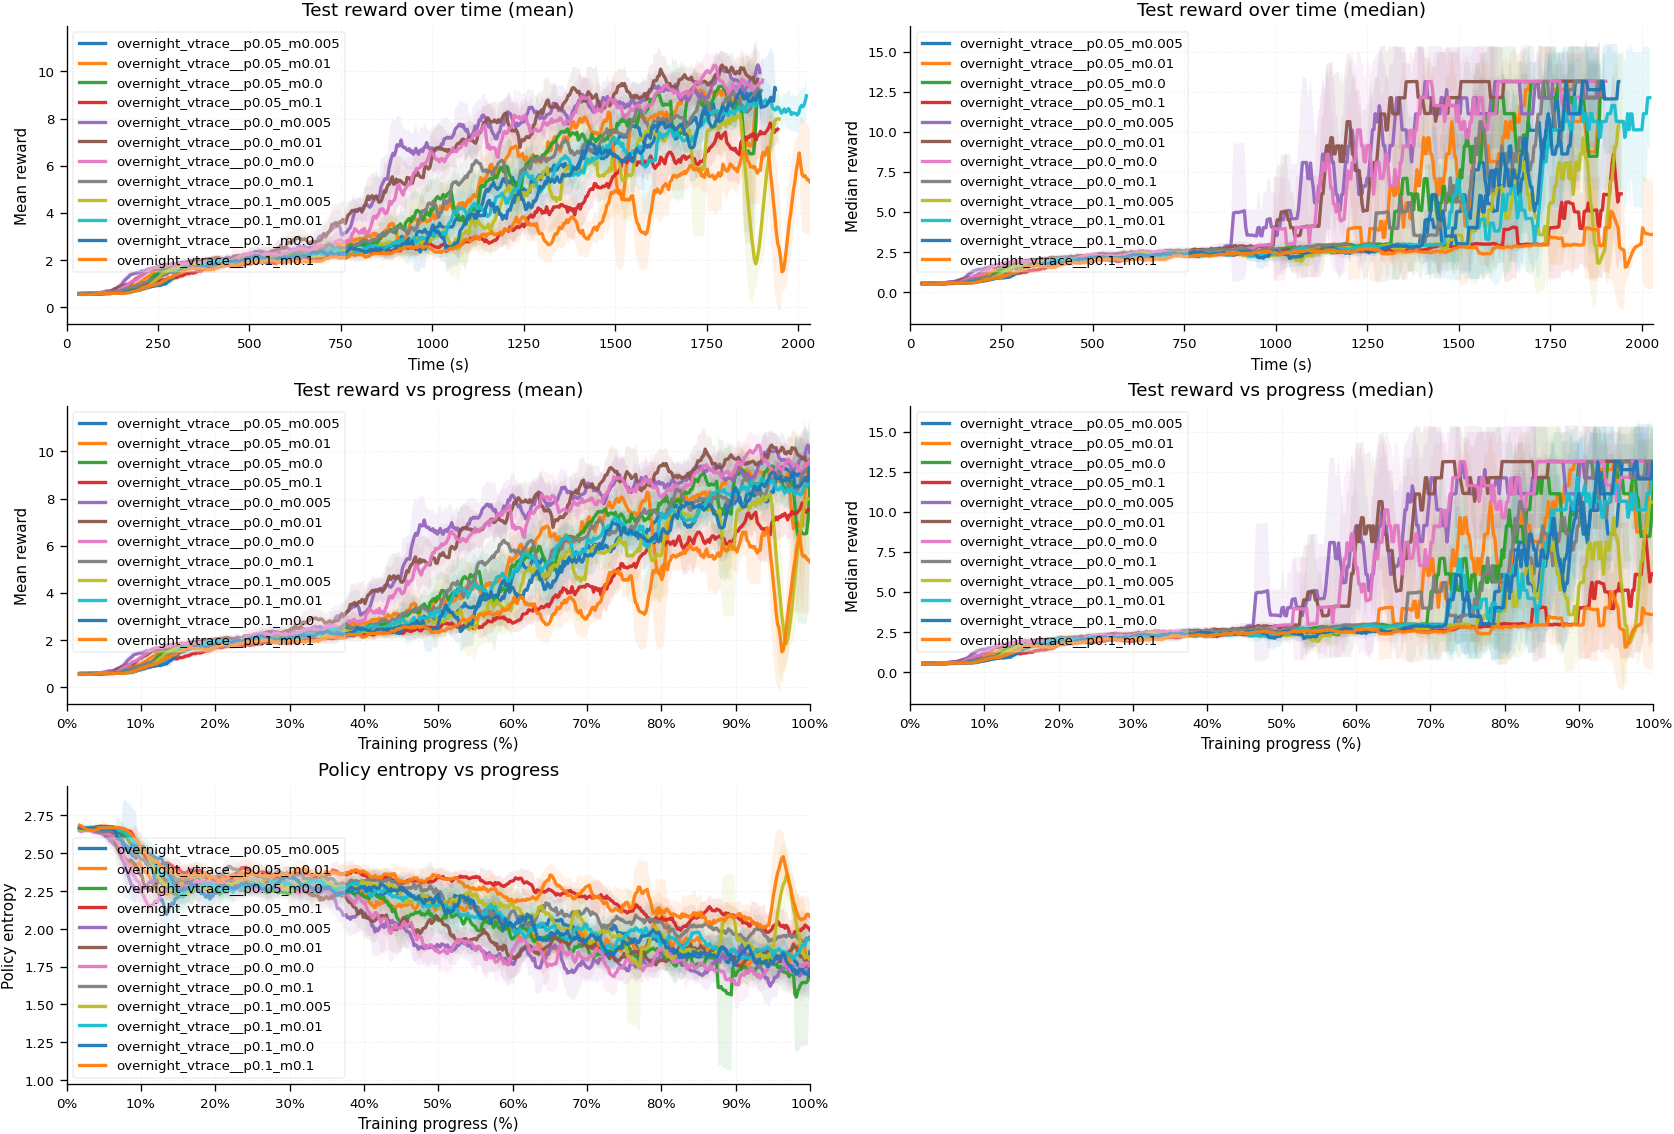

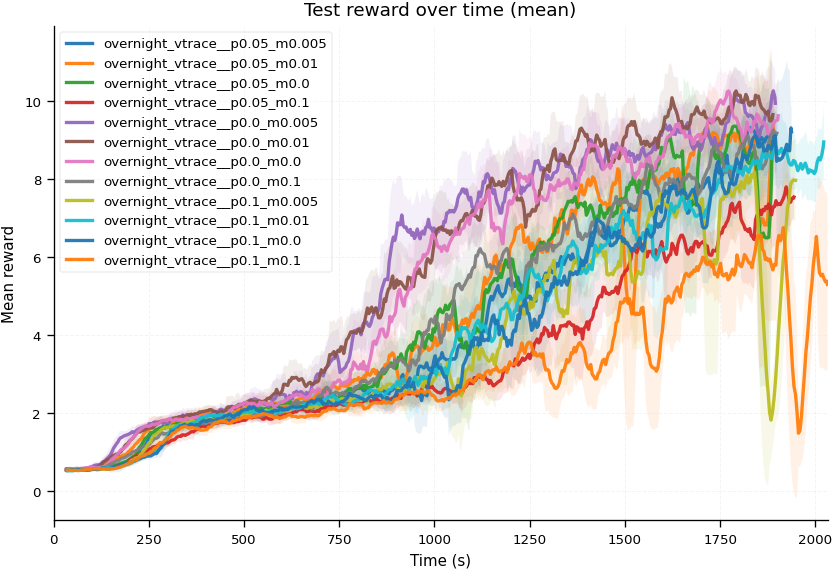

INFO | Saved plot: ./plots\test_reward_over_time__median_.png


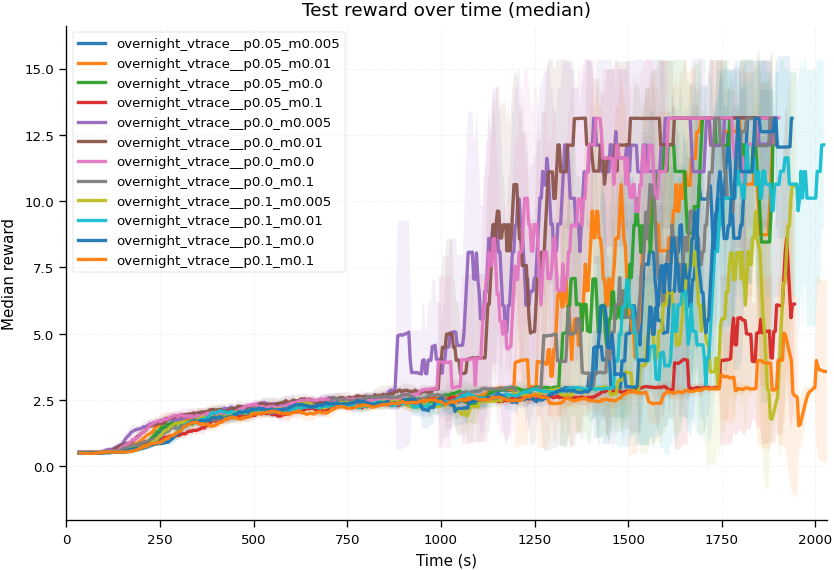

INFO | Saved plot: ./plots\test_reward_vs_progress__mean_.png


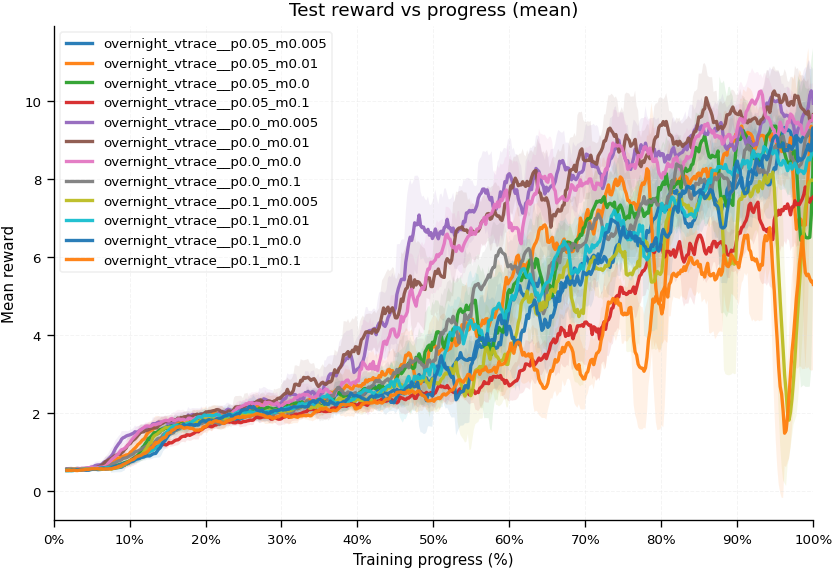

INFO | Saved plot: ./plots\test_reward_vs_progress__median_.png


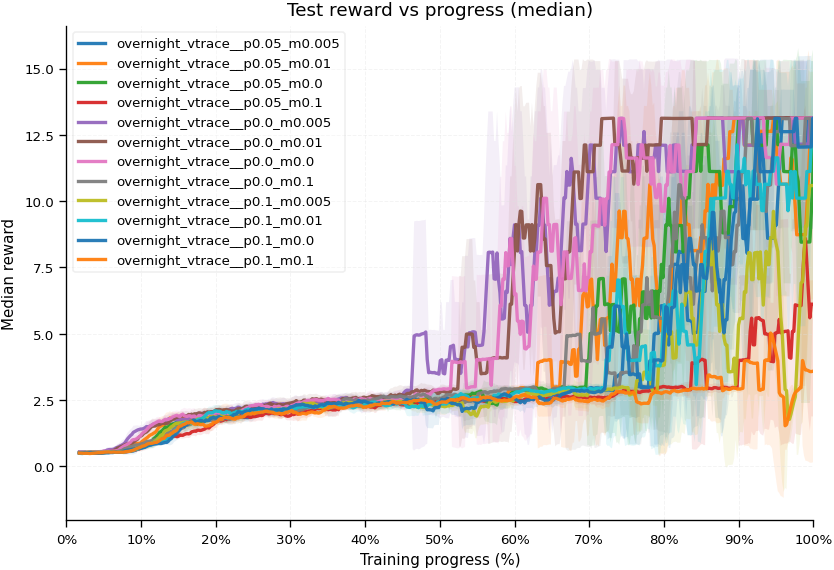

INFO | Saved plot: ./plots\policy_entropy_vs_progress.png


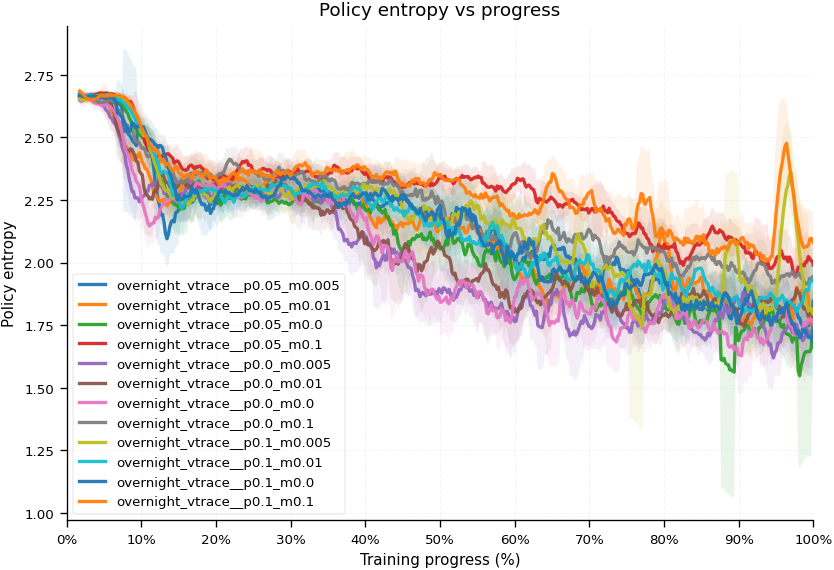

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import logging

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"

REQUIRED_COLS = [
    "training_time",
    "total_steps",
    "test/mean_reward",
    "test/median_reward",
    "loss/dist_entropy",
]

PLOTS = [
    {"x": "t", "y": "test/mean_reward", "xlabel": "Time (s)", "ylabel": "Mean reward", "title": "Test reward over time (mean)"},
    {"x": "t", "y": "test/median_reward", "xlabel": "Time (s)", "ylabel": "Median reward", "title": "Test reward over time (median)"},
    {"x": "steps_norm_global", "y": "test/mean_reward", "xlabel": "Training progress (%)", "ylabel": "Mean reward", "title": "Test reward vs progress (mean)"},
    {"x": "steps_norm_global", "y": "test/median_reward", "xlabel": "Training progress (%)", "ylabel": "Median reward", "title": "Test reward vs progress (median)"},
    {"x": "steps_norm_global", "y": "loss/dist_entropy", "xlabel": "Training progress (%)", "ylabel": "Policy entropy", "title": "Policy entropy vs progress"},
]

ROLL_WINDOW = 10
UNCERTAINTY_SCALE = 1.0
BAND_ALPHA = 0.10
STANDARD_ERROR_BANDS = False

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_plot")

def ensure_dirs():
    os.makedirs(ROOT_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def ensure_numeric(series, name):
    if series is None:
        raise ValueError(f"Column '{name}' missing")
    v = pd.to_numeric(series, errors="raise").astype(float).values
    if v.size == 0 or not np.isfinite(v).any():
        raise ValueError(f"Column '{name}' has no finite numeric values")
    return v

def build_time_seconds(df):
    t = ensure_numeric(df["training_time"], "training_time")
    t0 = np.nanmin(t)
    if not np.isfinite(t0):
        raise ValueError("training_time min not finite")
    if t0 != 0:
        t = t - t0
    return t

def normalize_time_per_run(t):
    total = np.nanmax(t)
    if not np.isfinite(total) or total <= 0:
        raise ValueError("training_time max invalid for normalization")
    return np.clip(t / float(total), 0.0, np.inf)

def build_steps(df):
    steps = ensure_numeric(df["total_steps"], "total_steps")
    s0 = np.nanmin(steps)
    if not np.isfinite(s0):
        raise ValueError("total_steps min not finite")
    if s0 != 0:
        steps = steps - s0
    return steps

def smooth_series(y):
    s = pd.Series(y, dtype=float)
    return s.rolling(ROLL_WINDOW, min_periods=ROLL_WINDOW).mean().values

def uncertainty_series(y):
    s = pd.Series(y, dtype=float)
    std = s.rolling(ROLL_WINDOW, min_periods=ROLL_WINDOW).std(ddof=1)
    if STANDARD_ERROR_BANDS:
        se = std / np.sqrt(ROLL_WINDOW)
        return se.values
    return std.values

def load_runs(root):
    paths = find_run_csvs(root, CSV_NAME)
    if not paths:
        logger.error(f"No CSVs named '{CSV_NAME}' found under root='{root}'")
        return pd.DataFrame()
    frames = []
    for p in paths:
        run = infer_run_name(p, root)
        try:
            df = pd.read_csv(p)
            missing = [c for c in REQUIRED_COLS if c not in df.columns]
            if missing:
                raise ValueError(f"Missing required columns: {missing}")
            t = build_time_seconds(df)
            tn = normalize_time_per_run(t)
            steps = build_steps(df)
            y_mean = ensure_numeric(df["test/mean_reward"], "test/mean_reward")
            y_median = ensure_numeric(df["test/median_reward"], "test/median_reward")
            entropy_col = ensure_numeric(df["loss/dist_entropy"], "loss/dist_entropy")
            sub = pd.DataFrame({
                "run": run,
                "t": t,
                "t_norm": tn,
                "steps": steps,
                "test/mean_reward": y_mean,
                "test/median_reward": y_median,
                "loss/dist_entropy": entropy_col,
            })
            sub = sub.sort_values("t_norm")
            frames.append(sub)
        except Exception as e:
            logger.error(f"[{run}] skipping due to error: {e}")
            continue
    if not frames:
        logger.error("No valid runs loaded after strict validation")
        return pd.DataFrame()
    df_all = pd.concat(frames, ignore_index=True)
    smax_global = np.nanmax(df_all["steps"].values)
    if not np.isfinite(smax_global) or smax_global <= 0:
        logger.error("Global total_steps max invalid for normalization")
        return df_all
    df_all["steps_norm_global"] = np.clip(df_all["steps"].values / float(smax_global), 0.0, 1.0)
    return df_all

def percent_formatter(ax):
    bp = np.arange(0.0, 1.0 + 1e-9, 0.1)
    ax.set_xticks(bp)
    ax.set_xticklabels([f"{int(v*100)}%" for v in bp])

def plot_runs(ax, df, runs, x, y, xlabel, ylabel, title):
    plotted_any = False
    for r in runs:
        d = df[df["run"] == r]
        xv = d[x].values
        yv = d[y].values
        if yv.size == 0 or np.all(~np.isfinite(yv)):
            logger.error(f"[{r}] plot '{title}' y='{y}' invalid; strict mode skips")
            continue
        ys = smooth_series(yv)
        u = uncertainty_series(yv)
        mask = np.isfinite(xv) & np.isfinite(ys) & np.isfinite(u)
        xv2, ys2, u2 = xv[mask], ys[mask], u[mask]
        if xv2.size == 0:
            logger.error(f"[{r}] plot '{title}' insufficient finite points after smoothing")
            continue
        ax.plot(xv2, ys2, label=r, linewidth=2.0, alpha=0.95)
        ax.fill_between(xv2, ys2 - UNCERTAINTY_SCALE * u2, ys2 + UNCERTAINTY_SCALE * u2, alpha=BAND_ALPHA, linewidth=0)
        plotted_any = True
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if x == "t_norm":
        ax.set_xlim(0, 1.0)
        percent_formatter(ax)
    elif x == "t":
        xmax = np.nanmax(df["t"].values)
        if np.isfinite(xmax):
            ax.set_xlim(0, xmax)
    elif x == "steps_norm_global":
        ax.set_xlim(0, 1.0)
        percent_formatter(ax)
    ax.grid(True, alpha=0.35)
    if plotted_any:
        ax.legend(loc="best", fontsize=8, framealpha=0.3)
    else:
        logger.error(f"No lines plotted for '{title}'")

def safe_filename(s):
    return "".join(c if c.isalnum() or c in "-_." else "_" for c in s).lower()

def save_plot(fig, name, dpi=200):
    os.makedirs(PLOTS_DIR, exist_ok=True)
    fname = safe_filename(name)
    path_png = os.path.join(PLOTS_DIR, f"{fname}.png")
    fig.savefig(path_png, dpi=dpi, bbox_inches="tight")
    logger.info(f"Saved plot: {path_png}")

def main():
    ensure_dirs()
    try:
        matplotlib.rcParams["figure.dpi"] = 120
        matplotlib.rcParams["savefig.dpi"] = 200
        matplotlib.rcParams["axes.spines.top"] = False
        matplotlib.rcParams["axes.spines.right"] = False
        matplotlib.rcParams["grid.linestyle"] = "--"
        matplotlib.rcParams["legend.frameon"] = True
        try:
            plt.rcParams["text.usetex"] = False
        except Exception:
            pass
    except Exception:
        pass
    df = load_runs(ROOT_DIR)
    if df.empty:
        print(f"No {CSV_NAME} files with required columns found under: {ROOT_DIR}")
        return
    runs = df["run"].unique().tolist()
    if not runs:
        print(f"No valid runs after strict validation under: {ROOT_DIR}")
        return
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(14, 9.5), constrained_layout=True)
    axes = axes.flatten()
    for i, cfg in enumerate(PLOTS):
        plot_runs(axes[i], df, runs, **cfg)
    for j in range(len(PLOTS), rows * cols):
        fig.delaxes(axes[j])
    save_plot(fig, "Summary grid")
    for i, cfg in enumerate(PLOTS[:len(PLOTS)]):
        f, ax = plt.subplots(1, 1, figsize=(7, 4.8), constrained_layout=True)
        plot_runs(ax, df, runs, **cfg)
        save_plot(f, f"{cfg['title']}")
        plt.show(block=False)
    plt.show()

if __name__ == "__main__":
    main()


,run,p,m,mean_lastN_winsor,median_lastN_winsor
0,overnight_vtrace__p0.05_m0.005,0.05,0.005,8.645547,11.2300
1,overnight_vtrace__p0.05_m0.01,0.05,0.010,8.939969,11.5350
2,overnight_vtrace__p0.05_m0.0,0.05,0.000,8.810877,11.7216
3,overnight_vtrace__p0.05_m0.1,0.05,0.100,7.236575,5.3804
4,overnight_vtrace__p0.0_m0.005,0.00,0.005,9.613939,13.1420
5,overnight_vtrace__p0.0_m0.01,0.00,0.010,9.830247,13.1432
6,overnight_vtrace__p0.0_m0.0,0.00,0.000,9.562686,13.1400
7,overnight_vtrace__p0.0_m0.1,0.00,0.100,8.730118,12.4756
8,overnight_vtrace__p0.1_m0.005,0.10,0.005,6.513059,7.3392
9,overnight_vtrace__p0.1_m0.01,0.10,0.010,8.569110,10.9346


,p,m,mean_lastN_winsor,median_lastN_winsor
0,0.00,0.000,9.562686,13.1400
1,0.00,0.005,9.613939,13.1420
2,0.00,0.010,9.830247,13.1432
3,0.00,0.100,8.730118,12.4756
4,0.05,0.000,8.810877,11.7216
5,0.05,0.005,8.645547,11.2300
6,0.05,0.010,8.939969,11.5350
7,0.05,0.100,7.236575,5.3804
8,0.10,0.000,8.821148,13.0696
9,0.10,0.005,6.513059,7.3392


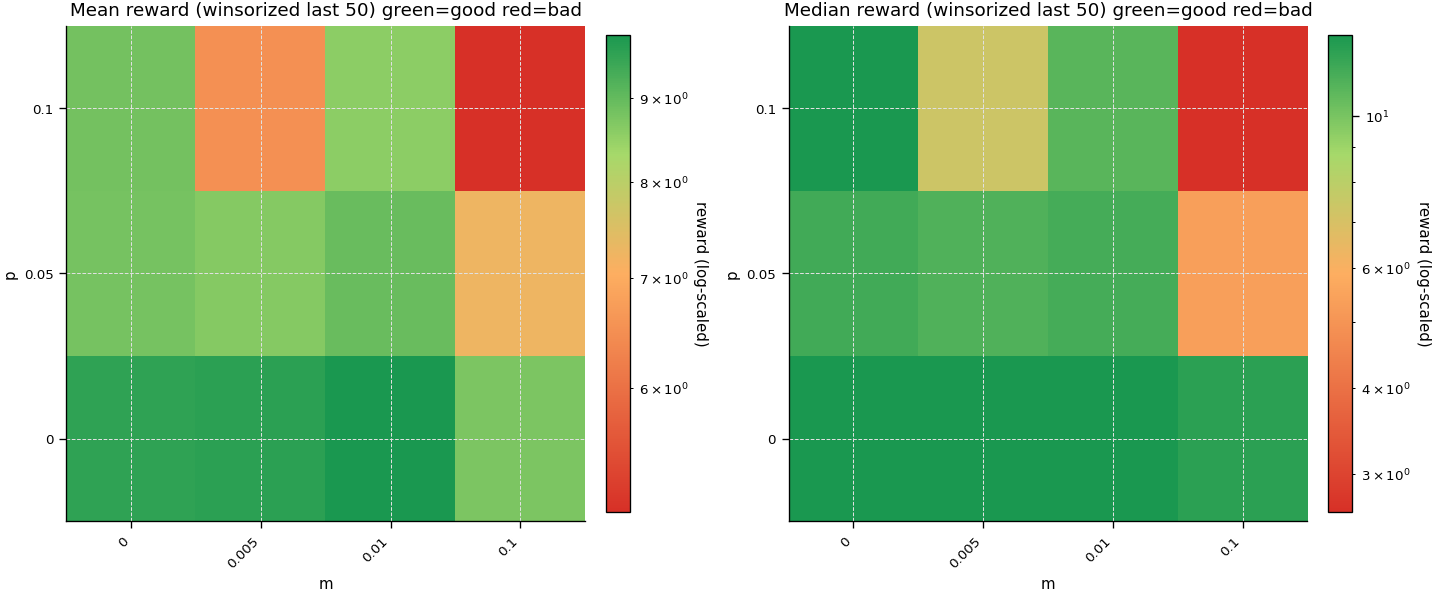

In [26]:
import os
import re
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, SymLogNorm

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"

Y_MEAN = "test/mean_episode_reward"
Y_MEDIAN = "test/median_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]
Y_MEDIAN_ALIASES = [Y_MEDIAN, "test/median_reward"]

LAST_N = 50
WINSOR_Q = 0.10

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_matrix_nb")

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    paths = sorted(paths)
    if not paths:
        logger.warning(f"No CSVs named '{csv_name}' found under root='{root}'")
    return paths

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_p_m_from_run(run_name):
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    if not np.isfinite(p) or not np.isfinite(m):
        logger.warning(f"[{run_name}] could not parse p/m from run name; got p={p}, m={m}")
    return p, m

def get_first_present(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def _nan_masked_tail(series, n):
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    if x.size == 0:
        return x
    n_eff = min(n, x.size) if n is not None and n > 0 else x.size
    return x[-n_eff:]

def winsorized_mean_lastN(series, n, q):
    x = _nan_masked_tail(series, n)
    if x.size == 0:
        return np.nan
    if x.size < 3:
        return float(np.mean(x))
    q = max(0.0, min(0.5, q))
    if q == 0.0:
        return float(np.mean(x))
    lo, hi = np.quantile(x, [q, 1 - q])
    xw = np.clip(x, lo, hi)
    return float(np.mean(xw))

def load_last_metrics(root):
    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception as e:
            logger.error(f"[{run}] failed to read CSV '{pth}': {e}")
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        y_median_col = get_first_present(df, Y_MEDIAN_ALIASES)
        if y_mean_col is None and y_median_col is None:
            logger.warning(f"[{run}] missing target columns; looked for {Y_MEAN_ALIASES} and {Y_MEDIAN_ALIASES}; skipping")
            continue
        mean_series = df.get(y_mean_col, pd.Series(dtype=float))
        median_series = df.get(y_median_col, pd.Series(dtype=float))
        mean_est = winsorized_mean_lastN(mean_series, LAST_N, WINSOR_Q) if y_mean_col is not None else np.nan
        median_est = winsorized_mean_lastN(median_series, LAST_N, WINSOR_Q) if y_median_col is not None else np.nan
        if np.isnan(mean_est) and np.isnan(median_est):
            logger.warning(f"[{run}] last-N robust estimators returned NaN for both mean/median; skipping")
            continue
        p_val, m_val = parse_p_m_from_run(run)
        rows.append({
            "run": run,
            "p": p_val,
            "m": m_val,
            "mean_lastN_winsor": mean_est,
            "median_lastN_winsor": median_est,
        })
    return rows

def build_matrices(rows):
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), np.array([[]]), pd.DataFrame(columns=["p","m","mean_lastN_winsor","median_lastN_winsor"])
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    mean_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    median_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    grouped = df.groupby(["p", "m"], dropna=True).agg({
        "mean_lastN_winsor": "mean",
        "median_lastN_winsor": "mean"
    }).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, row in grouped.iterrows():
        p, m = row["p"], row["m"]
        if p in p_index and m in m_index:
            i, j = p_index[p], m_index[m]
            mean_matrix[i, j] = row["mean_lastN_winsor"]
            median_matrix[i, j] = row["median_lastN_winsor"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "mean_lastN_winsor": mean_matrix.reshape(-1),
        "median_lastN_winsor": median_matrix.reshape(-1),
    })
    return P_vals, M_vals, mean_matrix, median_matrix, tidy

def make_green_good_red_bad_cmap():
    colors = [
        (0.0, "#d73027"),
        (0.5, "#fdae61"),
        (0.75, "#a6d96a"),
        (1.0, "#1a9850"),
    ]
    return LinearSegmentedColormap.from_list("red_yellow_green", colors)

rows = load_last_metrics(ROOT_DIR)
if not rows:
    print(f"No valid runs found to build matrices from: {ROOT_DIR}")
else:
    P_vals, M_vals, mean_matrix, median_matrix, tidy = build_matrices(rows)

    try:
        display(pd.DataFrame(rows))
        display(tidy)
    except NameError:
        print(pd.DataFrame(rows).head())
        print(tidy.head())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    cmap = make_green_good_red_bad_cmap()

    def imshow_with_axes(ax, matrix, P_vals, M_vals, title):
        finite_vals = matrix[np.isfinite(matrix)]
        if finite_vals.size == 0:
            vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = np.nanmin(finite_vals), np.nanmax(finite_vals)
            if np.isclose(vmin, vmax):
                delta = 1.0 if vmax == 0 else abs(vmax) * 0.1
                vmin, vmax = vmax - delta, vmax + delta
        if finite_vals.size == 0:
            norm = LogNorm(vmin=1e-6, vmax=1.0)
        elif np.all(finite_vals > 0):
            eps = np.nextafter(0, 1)
            norm = LogNorm(vmin=max(vmin, eps), vmax=vmax)
        else:
            linthresh = max(1e-6, 0.01 * max(1e-9, (vmax - vmin)))
            norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)
        im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)
        ax.set_title(title)
        ax.set_xlabel("m")
        ax.set_ylabel("p")
        ax.set_xticks(range(len(M_vals)))
        ax.set_yticks(range(len(P_vals)))
        ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=45, ha="right")
        ax.set_yticklabels([f"{p:g}" for p in P_vals])
        im.cmap.set_bad(color="#bdbdbd")
        im.set_data(np.ma.masked_invalid(matrix))
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("reward (log-scaled)", rotation=270, labelpad=12)

    imshow_with_axes(axes[0], mean_matrix, P_vals, M_vals, f"Mean reward (winsorized last {LAST_N}) green=good red=bad")
    imshow_with_axes(axes[1], median_matrix, P_vals, M_vals, f"Median reward (winsorized last {LAST_N}) green=good red=bad")

    plt.show()


,run,p,m,mean_max
0,overnight_vtrace__p0.05_m0.005,0.05,0.005,10.7069
1,overnight_vtrace__p0.05_m0.01,0.05,0.010,10.7262
2,overnight_vtrace__p0.05_m0.0,0.05,0.000,10.8412
3,overnight_vtrace__p0.05_m0.1,0.05,0.100,9.1944
4,overnight_vtrace__p0.0_m0.005,0.00,0.005,10.9800
5,overnight_vtrace__p0.0_m0.01,0.00,0.010,11.5650
6,overnight_vtrace__p0.0_m0.0,0.00,0.000,11.5481
7,overnight_vtrace__p0.0_m0.1,0.00,0.100,11.0181
8,overnight_vtrace__p0.1_m0.005,0.10,0.005,9.8669
9,overnight_vtrace__p0.1_m0.01,0.10,0.010,10.3519


,p,m,mean_max
0,0.00,0.000,11.5481
1,0.00,0.005,10.9800
2,0.00,0.010,11.5650
3,0.00,0.100,11.0181
4,0.05,0.000,10.8412
5,0.05,0.005,10.7069
6,0.05,0.010,10.7262
7,0.05,0.100,9.1944
8,0.10,0.000,10.5231
9,0.10,0.005,9.8669


Saved heatmap to './plots\mean_reward_matrix.png'


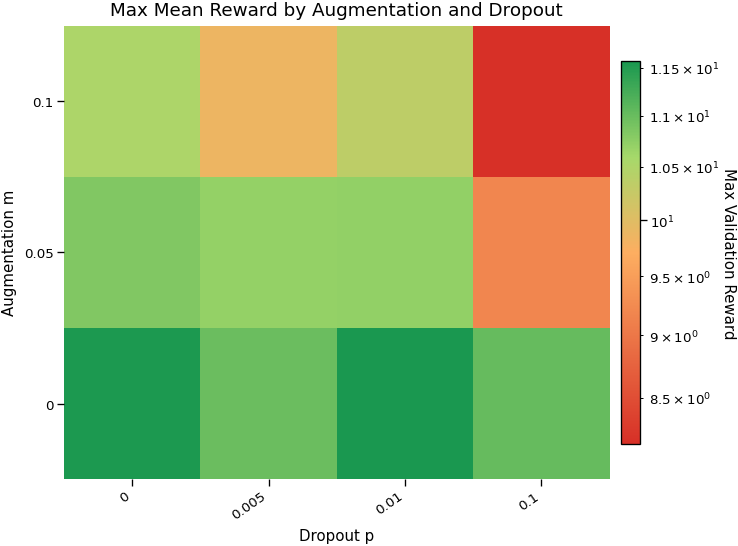

In [27]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, SymLogNorm
from typing import List, Tuple, Dict, Any

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
PNG_NAME = "mean_reward_matrix.png"

Y_MEAN = "test/mean_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]

def find_run_csvs(root: str, csv_name: str) -> List[str]:
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    paths = sorted(paths)
    return paths

def infer_run_name(path: str, root: str) -> str:
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_p_m_from_run(run_name: str) -> Tuple[float, float]:
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    return p, m

def get_first_present(df: pd.DataFrame, names: List[str]) -> str | None:
    for n in names:
        if n in df.columns:
            return n
    return None

def mean_max(series: pd.Series | List[Any]) -> float:
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    if x.size == 0:
        return np.nan
    return float(np.max(x))

def load_metrics_max_mean(root: str) -> List[Dict[str, Any]]:
    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception:
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        if y_mean_col is None:
            continue
        mean_series = df.get(y_mean_col, pd.Series(dtype=float))
        mean_est = mean_max(mean_series)
        if np.isnan(mean_est):
            continue
        p_val, m_val = parse_p_m_from_run(run)
        rows.append({"run": run, "p": p_val, "m": m_val, "mean_max": mean_est})
    return rows

def build_matrix(rows: List[Dict[str, Any]]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), pd.DataFrame(columns=["p","m","mean_max"])
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    mean_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    grouped = df.groupby(["p", "m"], dropna=False).agg({"mean_max": "mean"}).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, row in grouped.iterrows():
        p, m = row["p"], row["m"]
        if p in p_index and m in m_index:
            i, j = p_index[p], m_index[m]
            mean_matrix[i, j] = row["mean_max"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "mean_max": mean_matrix.reshape(-1),
    })
    return P_vals, M_vals, mean_matrix, tidy

def make_green_good_red_bad_cmap() -> LinearSegmentedColormap:
    colors = [(0.0, "#d73027"), (0.5, "#fdae61"), (0.75, "#a6d96a"), (1.0, "#1a9850")]
    return LinearSegmentedColormap.from_list("red_yellow_green", colors)

def _auto_norm(matrix: np.ndarray):
    finite_vals = matrix[np.isfinite(matrix)]
    if finite_vals.size == 0:
        return 0.0, 1.0, LogNorm(vmin=1e-6, vmax=1.0)
    vmin, vmax = np.nanmin(finite_vals), np.nanmax(finite_vals)
    if np.isclose(vmin, vmax):
        delta = 1.0 if vmax == 0 else abs(vmax) * 0.1
        vmin, vmax = vmax - delta, vmax + delta
    if np.all(finite_vals > 0):
        eps = np.nextafter(0, 1)
        return vmin, vmax, LogNorm(vmin=max(vmin, eps), vmax=vmax)
    linthresh = max(1e-6, 0.01 * max(1e-9, (vmax - vmin)))
    return vmin, vmax, SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

def _imshow(ax, matrix: np.ndarray, P_vals: np.ndarray, M_vals: np.ndarray, title: str, fig: plt.Figure, cmap: LinearSegmentedColormap):
    vmin, vmax, norm = _auto_norm(matrix)
    im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm, interpolation="nearest")
    ax.set_title(title, pad=6)
    ax.set_ylabel("Augmentation m", labelpad=4)
    ax.set_xlabel("Dropout p", labelpad=4)
    ax.set_xticks(range(len(M_vals)))
    ax.set_yticks(range(len(P_vals)))
    ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=35, ha="right")
    ax.set_yticklabels([f"{p:g}" for p in P_vals])
    ax.tick_params(axis="both", which="both", labelsize=8, pad=2)
    im.cmap.set_bad(color="#bdbdbd")
    im.set_data(np.ma.masked_invalid(matrix))
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
    cbar.ax.tick_params(labelsize=8, pad=2)
    cbar.ax.set_ylabel("Max Validation Reward", rotation=270, labelpad=10)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

def ensure_dir(path: str):
    try:
        os.makedirs(path, exist_ok=True)
    except Exception:
        pass

def main():
    rows = load_metrics_max_mean(ROOT_DIR)
    if not rows:
        print(f"No valid runs found to build matrix from: {ROOT_DIR}")
        return
    P_vals, M_vals, mean_matrix, tidy = build_matrix(rows)
    try:
        display(pd.DataFrame(rows))
        display(tidy)
    except NameError:
        print(pd.DataFrame(rows).head())
        print(tidy.head())
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.titlesize": 11,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.titlepad": 6,
    })
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.6), constrained_layout=True)
    cmap = make_green_good_red_bad_cmap()
    _imshow(ax, mean_matrix, P_vals, M_vals, "Max Mean Reward by Augmentation and Dropout", fig, cmap)
    ensure_dir(PLOTS_DIR)
    out_path = os.path.join(PLOTS_DIR, PNG_NAME)
    try:
        fig.savefig(out_path, bbox_inches="tight")
        print(f"Saved heatmap to '{out_path}'")
    except Exception:
        print(f"Failed to save figure to '{out_path}'")
    plt.show()

if __name__ == "__main__":
    main()


Saved side-by-side plot to './plots\vtrace_drac_chaser_fruitbot.png'


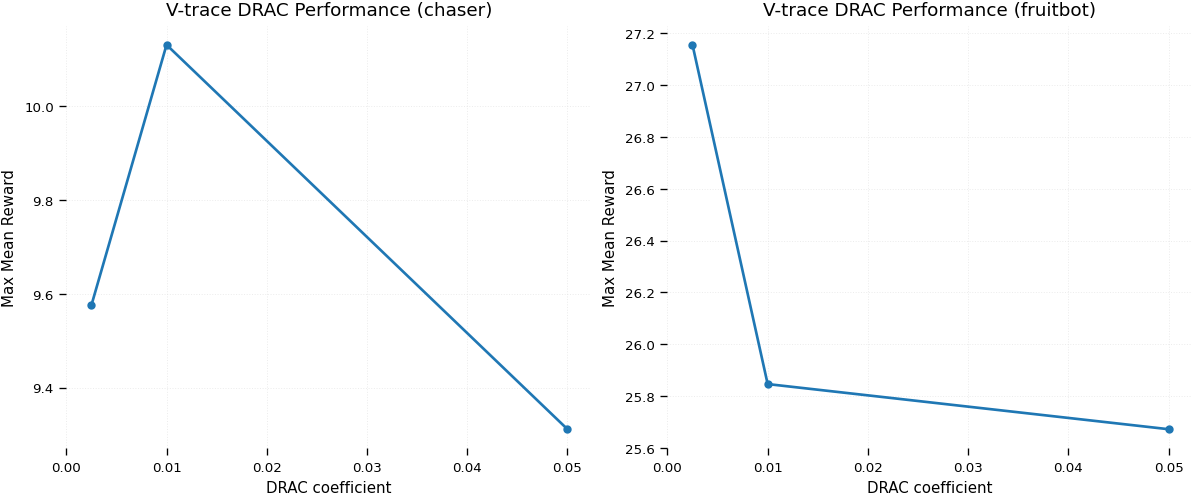

In [30]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
OUT_NAME = "vtrace_drac_chaser_fruitbot.png"
Y_MEAN_ALIASES = ["test/mean_episode_reward", "test/mean_reward"]

def find_run_csvs(root: str, csv_name: str) -> List[str]:
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)

def infer_run_name(path: str, root: str) -> str:
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_tokens(run_name: str) -> Dict[str, Any]:
    algo = "vtrace" if "vtrace" in run_name else None
    drac = "drac" if "drac" in run_name else None
    m = re.search(r"drac[_\-]?([0-9]*\.?[0-9]+(?:[eE][+\-]?\d+)?)", run_name)
    drac_val = float(m.group(1)) if m else np.nan
    env = "fruitbot" if "fruitbot" in run_name else ("chaser" if "chaser" in run_name else None)
    return {"algo": algo, "drac": drac, "drac_val": drac_val, "env": env}

def get_first_present(df: pd.DataFrame, candidates: List[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def mean_max(series) -> float:
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    return float(np.max(x)) if x.size else np.nan

def load_rows(root: str) -> List[Dict[str, Any]]:
    rows = []
    for pth in find_run_csvs(root, CSV_NAME):
        run = infer_run_name(pth, root)
        toks = parse_tokens(run)
        if toks["algo"] != "vtrace" or toks["drac"] != "drac" or toks["env"] not in ("fruitbot", "chaser"):
            continue
        try:
            df = pd.read_csv(pth)
        except Exception:
            continue
        ycol = get_first_present(df, Y_MEAN_ALIASES)
        if not ycol:
            continue
        val = mean_max(df[ycol])
        if np.isnan(val):
            continue
        rows.append({"run": run, "env": toks["env"], "drac": toks["drac_val"], "reward": val})
    return rows

def ensure_zero_row(df_env: pd.DataFrame) -> pd.DataFrame:
    if df_env.empty:
        return df_env
    if not np.isclose(df_env["drac"].fillna(np.inf).values, 0.0).any():
        zero_reward = np.nan
        df_env = pd.concat([df_env, pd.DataFrame([{"env": df_env["env"].iloc[0], "drac": 0.0, "reward": zero_reward}])], ignore_index=True)
    return df_env

def plot_side_by_side(df: pd.DataFrame, out_dir: str, out_name: str):
    ch = df[df["env"] == "chaser"].copy()
    fr = df[df["env"] == "fruitbot"].copy()
    ch = ensure_zero_row(ch)
    fr = ensure_zero_row(fr)
    ch = ch.sort_values("drac")
    fr = fr.sort_values("drac")
    if ch.empty and fr.empty:
        print("No DRAC runs found for chaser or fruitbot")
        return
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.titlesize": 11,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.titlepad": 6,
    })
    fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2), constrained_layout=True, sharey=False)

    def _one(ax, sub, title):
        if sub.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            ax.set_title(title)
            ax.set_xlabel("DRAC coefficient")
            return
        x = sub["drac"].values
        y = sub["reward"].values
        ax.plot(x, y, marker="o", linestyle="-", linewidth=1.6, markersize=4)
        ax.set_title(title)
        ax.set_xlabel("DRAC coefficient")
        ax.set_xlim(left=0.0)
        ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
        for spine in ax.spines.values():
            spine.set_visible(False)

    _one(axes[0], ch, "V-trace DRAC Performance (chaser)")
    _one(axes[1], fr, "V-trace DRAC Performance (fruitbot)")
    axes[0].set_ylabel("Max Mean Reward")
    axes[1].set_ylabel("Max Mean Reward")
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, out_name)
    fig.savefig(out_path, bbox_inches="tight")
    print(f"Saved side-by-side plot to '{out_path}'")
    plt.show()

def main():
    rows = load_rows(ROOT_DIR)
    if not rows:
        print("No DRAC runs found")
        return
    df = pd.DataFrame(rows)
    plot_side_by_side(df, PLOTS_DIR, OUT_NAME)

if __name__ == "__main__":
    main()
